### 1. Data preparation

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

np.random.seed(42)

[nltk_data] Downloading package stopwords to C:\Users\UDIT
[nltk_data]     DAGAR\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\UDIT
[nltk_data]     DAGAR\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [11]:
import sys
print(sys.version)

3.10.11 | packaged by Anaconda, Inc. | (main, May 16 2023, 00:55:32) [MSC v.1916 64 bit (AMD64)]


In [ ]:
true_df = pd.read_csv('dataset/True.csv')
fake_df = pd.read_csv('dataset/Fake.csv')

true_df['label'] = 0
fake_df['label'] = 1

df = pd.concat([true_df, fake_df], axis=0)

df = shuffle(df, random_state=42).reset_index(drop=True)

Total number of samples: 44898
Number of real news: 21417
Number of fake news: 23481

Missing values per column:
title      0
text       0
subject    0
date       0
label      0
dtype: int64


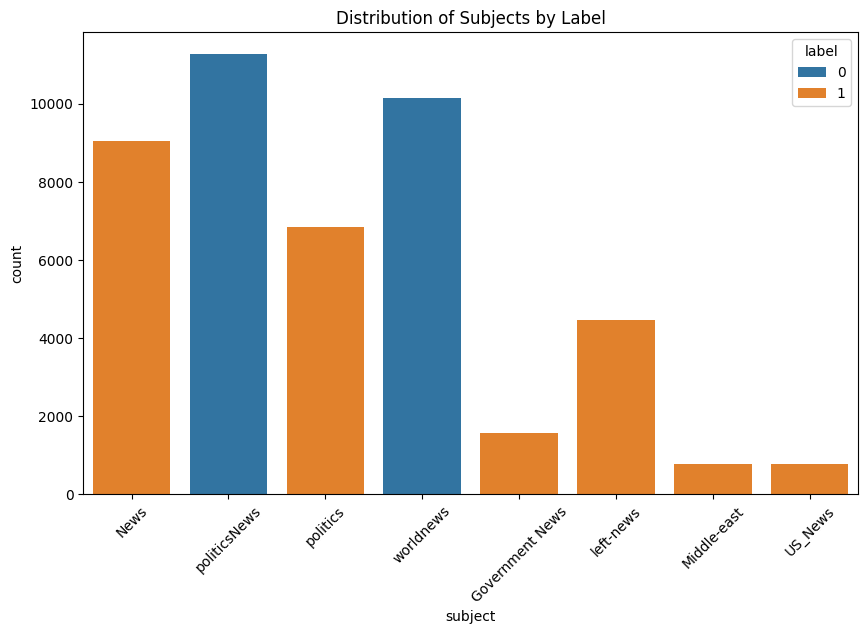

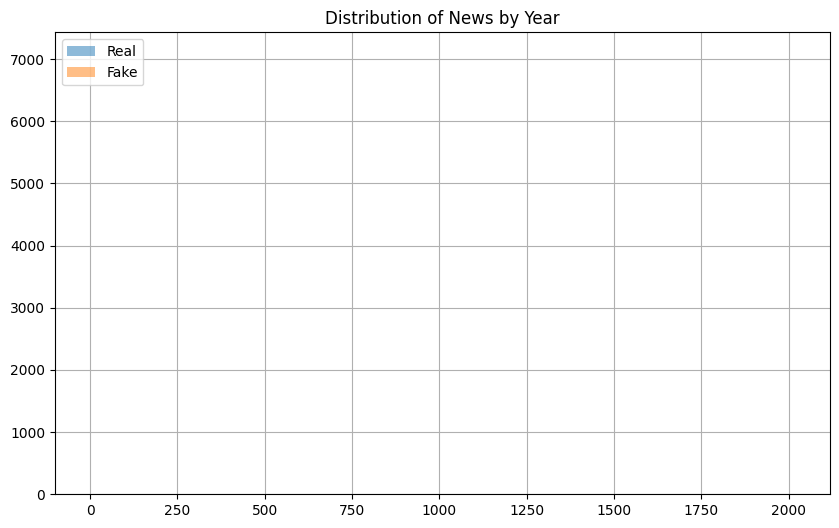

In [ ]:
print(f"Total number of samples: {len(df)}")
print(f"Number of real news: {len(df[df['label']==0])}")
print(f"Number of fake news: {len(df[df['label']==1])}\n")

print("Missing values per column:")
print(df.isnull().sum())

plt.figure(figsize=(10,6))
sns.countplot(x='subject', hue='label', data=df)
plt.title('Distribution of Subjects by Label')
plt.xticks(rotation=45)
plt.show()

if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'], errors='coerce')
    plt.figure(figsize=(10,6))
    df[df['label']==0]['date'].dt.year.hist(alpha=0.5, bins=30, label='Real')
    df[df['label']==1]['date'].dt.year.hist(alpha=0.5, bins=30, label='Fake')
    plt.title('Distribution of News by Year')
    plt.legend()
    plt.show()

In [ ]:
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Clean and preprocess text data
    """
    if not isinstance(text, str):
        return ""
    
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text, re.I|re.A)
    tokens = text.split()
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    clean_text = ' '.join(tokens)
    
    return clean_text

df['combined_text'] = df['title'] + ' ' + df['text']

df['clean_text'] = df['combined_text'].apply(preprocess_text)
print("Original text example:\n", df['text'].iloc[0][:200], "...")
print("\nCleaned text example:\n", df['clean_text'].iloc[0][:200], "...")

Original text example:
 Donald Trump s White House is in chaos, and they are trying to cover it up. Their Russia problems are mounting by the hour, and they refuse to acknowledge that there are problems surrounding all of th ...

Cleaned text example:
 breaking gop chairman grassley enough demand trump jr testimony donald trump white house chaos trying cover russia problem mounting hour refuse acknowledge problem surrounding fake news hoax however f ...


In [ ]:
empty_text = df[df['clean_text'].str.len() == 0]
print(f"Number of empty texts after cleaning: {len(empty_text)}")

df = df[df['clean_text'].str.len() > 0]

duplicates = df.duplicated(subset=['clean_text'])
print(f"Number of duplicate texts: {duplicates.sum()}")

df = df[~duplicates]

df = df.reset_index(drop=True)

Number of empty texts after cleaning: 0
Number of duplicate texts: 5924


In [ ]:
final_df = df[['clean_text', 'label']].copy()

print("\nFinal class distribution:")
print(final_df['label'].value_counts(normalize=True))

final_df.to_csv('dataset/cleaned_news.csv', index=False)

print("\nData preparation complete!")


Final class distribution:
label
0    0.540591
1    0.459409
Name: proportion, dtype: float64

Data preparation complete!


### 2. Feature Engineering

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
X = final_df['clean_text']
y = final_df['label']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Training set size: {len(X_train)}")
print(f"Validation set size: {len(X_val)}")
print(f"Test set size: {len(X_test)}")

Training set size: 27281
Validation set size: 5846
Test set size: 5847


In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)

X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

print("\nTF-IDF shape for training set:", X_train_tfidf.shape)


TF-IDF shape for training set: (27281, 5000)


In [ ]:
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1
print(f"\nVocabulary size: {vocab_size}")

print("\nOriginal text:", X_train.iloc[0][:100], "...")
print("Converted sequence:", X_train_seq[0][:10], "...")


Vocabulary size: 164061

Original text: republican unveil tax cut bill hard work awaits washington reuters u house representative republican ...
Converted sequence: [8, 1, 64, 304, 59, 484, 116, 1, 41, 12] ...


In [ ]:
lengths = [len(seq) for seq in X_train_seq]
max_len = int(np.percentile(lengths, 95))

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("\nPadded sequence shape:", X_train_pad.shape)
print("Example padded sequence:", X_train_pad[0][:10], "...")


Padded sequence shape: (27281, 514)
Example padded sequence: [  8   1  64 304  59 484 116   1  41  12] ...


In [ ]:
X_train_tfidf_dense = X_train_tfidf.toarray()
X_val_tfidf_dense = X_val_tfidf.toarray()
X_test_tfidf_dense = X_test_tfidf.toarray()

X_train_tfidf_reshaped = X_train_tfidf_dense.reshape(X_train_tfidf_dense.shape[0], 1, X_train_tfidf_dense.shape[1])
X_val_tfidf_reshaped = X_val_tfidf_dense.reshape(X_val_tfidf_dense.shape[0], 1, X_val_tfidf_dense.shape[1])
X_test_tfidf_reshaped = X_test_tfidf_dense.reshape(X_test_tfidf_dense.shape[0], 1, X_test_tfidf_dense.shape[1])

print("\nReshaped TF-IDF features for neural network:", X_train_tfidf_reshaped.shape)


Reshaped TF-IDF features for neural network: (27281, 1, 5000)


In [ ]:
import pickle

with open('dataset/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('dataset/tfidf_vectorizer.pickle', 'wb') as handle:
    pickle.dump(tfidf_vectorizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

np.savez('dataset/prepared_data.npz',
         X_train_pad=X_train_pad,
         X_val_pad=X_val_pad,
         X_test_pad=X_test_pad,
         X_train_tfidf=X_train_tfidf_dense,
         X_val_tfidf=X_val_tfidf_dense,
         X_test_tfidf=X_test_tfidf_dense,
         y_train=y_train,
         y_val=y_val,
         y_test=y_test)

### 3. Building the BiLSTM

In [25]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Bidirectional, LSTM, Dense, Dropout, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

In [ ]:
def create_hybrid_model(vocab_size, max_len, tfidf_dim):
    """
    Create a hybrid model combining BiLSTM and TF-IDF features
    """
    text_input = Input(shape=(max_len,), name='text_input')
    
    embedding = Embedding(input_dim=vocab_size, 
                         output_dim=128, 
                         input_length=max_len,
                         mask_zero=True)(text_input)
    
    bilstm = Bidirectional(LSTM(64, return_sequences=True))(embedding)
    bilstm = Dropout(0.3)(bilstm)
    bilstm = Bidirectional(LSTM(32))(bilstm)
    bilstm = Dropout(0.3)(bilstm)
    
    tfidf_input = Input(shape=(tfidf_dim,), name='tfidf_input')
    
    tfidf_dense = Dense(64, activation='relu')(tfidf_input)
    tfidf_dense = Dropout(0.2)(tfidf_dense)
    
    combined = Concatenate()([bilstm, tfidf_dense])
    
    dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
    dense = Dropout(0.3)(dense)
    output = Dense(1, activation='sigmoid')(dense)
    
    model = Model(inputs=[text_input, tfidf_input], outputs=output)
    
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

model = create_hybrid_model(vocab_size=vocab_size,
                           max_len=max_len,
                           tfidf_dim=X_train_tfidf_dense.shape[1])

model.summary()

d:\Fake_News_Detection\venv\lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ text_input          │ (None, 514)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 514, 128)  │ 20,999,808 │ text_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 514)       │          0 │ text_input[0][0]  │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 514, 128)  │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 514, 128)  │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ tfidf_input         │ (None, 5000)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 64)        │     41,216 │ dropout[0][0],    │
│ (Bidirectional)     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │    320,064 │ tfidf_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ dropout_1[0][0],  │
│ (Concatenate)       │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │         65 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 21,468,225 (81.89 MB)

 Trainable params: 21,468,225 (81.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', 
                              patience=3, 
                              restore_best_weights=True)

model_checkpoint = ModelCheckpoint('best_model.h5', 
                                 monitor='val_accuracy', 
                                 save_best_only=True, 
                                 mode='max')

In [ ]:
history = model.fit(
    x={'text_input': X_train_pad, 'tfidf_input': X_train_tfidf_dense},
    y=y_train,
    validation_data=(
        {'text_input': X_val_pad, 'tfidf_input': X_val_tfidf_dense},
        y_val
    ),
    epochs=15,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9381 - loss: 0.4895

427/427 ━━━━━━━━━━━━━━━━━━━━ 586s 1s/step - accuracy: 0.9382 - loss: 0.4888 - val_accuracy: 0.9962 - val_loss: 0.0240
Epoch 2/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9988 - loss: 0.0160

427/427 ━━━━━━━━━━━━━━━━━━━━ 565s 1s/step - accuracy: 0.9988 - loss: 0.0160 - val_accuracy: 0.9978 - val_loss: 0.0136
Epoch 3/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9996 - loss: 0.0080

427/427 ━━━━━━━━━━━━━━━━━━━━ 612s 1s/step - accuracy: 0.9996 - loss: 0.0080 - val_accuracy: 0.9986 - val_loss: 0.0114
Epoch 4/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 568s 1s/step - accuracy: 0.9997 - loss: 0.0056 - val_accuracy: 0.9986 - val_loss: 0.0105
Epoch 5/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 595s 1s/step - accuracy: 0.9999 - loss: 0.0037 - val_accuracy: 0.9983 - val_loss: 0.0124
Epoch 6/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 624s 1s/step - accuracy: 0.9999 - loss: 0.0035 - val_accuracy: 0.9985 - val_loss: 0.0100
Epoch 7/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 656s 2s/step - accuracy: 0.9997 - loss: 0.0028 - val_accuracy: 0.9985 - val_loss: 0.0108
Epoch 8/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 623s 1s/step - accuracy: 1.0000 - loss: 0.0018 - val_accuracy: 0.9981 - val_loss: 0.0115
Epoch 9/15
427/427 ━━━━━━━━━━━━━━━━━━━━ 646s 2s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.9985 - val_loss: 0.0132


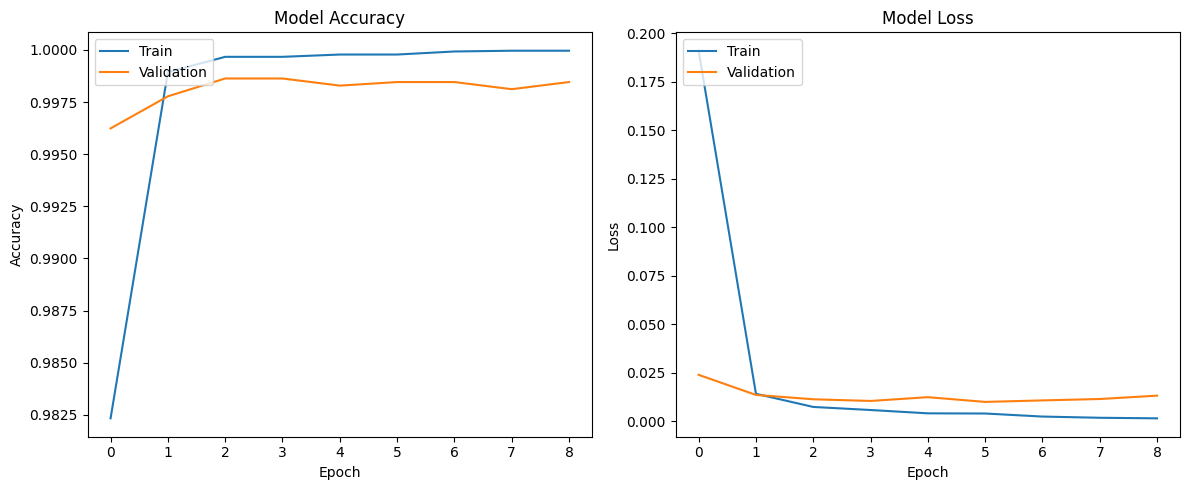

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()